# "Tutorial: TMVA PyTorch Interface"
> "Get started with TMVA PyTorch Interface. Combine the power of PyTorch & ROOT!"

- toc: true
- branch: master
- badges: true
- comments: true
- author: Anirudh Dagar
- categories: [tmva, pytorch, root]
- image: images/tmva.jpg

### Introduction
This tutorial aims to walkthrough the latest addition in the [ROOT TMVA](https://github.com/root-project/root) module, **The PyTorch Interface!** This is specifically designed to utilize the puissance of [ROOT](http://root.cern.ch/) for working with high energy physics data, while leveraging the power and flexibility of the popular Machine Learning framework, PyTorch.

The PyTorch interface allows HEP Scientists to be more ingenious with ideas and provides the ability to customize Machine Learning models to a far more preponderant extent than the Keras Interface.

Here, we'll build a simple classifier in python using PyTorch and compare the performance to a few other methods on a test example root dataset. The same model can be achieved in C/C++ like other TMVA methods which are implemented in C/C++. You can follow [this](https://github.com/root-project/root/tree/master/tmva/pymva/test/testPyTorchClassification.C) if you prefer a C++ implementation.

### Imports
We start with importing the necessary modules required for the tutorial

In [1]:
from ROOT import TMVA, TFile, TTree, TCut
from subprocess import call
from os.path import isfile

import torch
from torch import nn

Welcome to JupyROOT 6.23/01


### Setup TMVA

TMVA requires initialization the PyMVA to utilize PyTorch. PyMVA is the interface for third-party MVA tools based on Python. It is created to make powerful external libraries easily accessible with a direct integration into the TMVA workflow. All PyMVA methods provide the same plug-and-play mechanisms as the TMVA methods. Because the base method of PyMVA is inherited from the TMVA base method, all options of internal TMVA methods apply for PyMVA methods as well.

In [2]:
TMVA.Tools.Instance()
TMVA.PyMethodBase.PyInitialize()

output = TFile.Open('TMVA.root', 'RECREATE')
factory = TMVA.Factory('TMVAClassification', output,
                       '!V:!Silent:Color:DrawProgressBar:'
                       'Transformations=D,G:AnalysisType=Classification')

### DataLoader

Below we start by downloading the dataset example dataset. The signal and background are loaded and read from the dataset. Finally we define our dataloader with options to help us control the split.

In [3]:
if not isfile('tmva_class_example.root'):
    call(['curl', '-O', 'http://root.cern.ch/files/tmva_class_example.root'])

data = TFile.Open('tmva_class_example.root')
signal = data.Get('TreeS')
background = data.Get('TreeB')

dataloader = TMVA.DataLoader('dataset')
for branch in signal.GetListOfBranches():
    dataloader.AddVariable(branch.GetName())

dataloader.AddSignalTree(signal, 1.0)
dataloader.AddBackgroundTree(background, 1.0)
dataloader.PrepareTrainingAndTestTree(TCut(''),
                                      'nTrain_Signal=4000:'
                                      'nTrain_Background=4000:'
                                      'SplitMode=Random:'
                                      'NormMode=NumEvents:!V')

DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree TreeS of type Signal with 6000 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree TreeB of type Background with 6000 events
                         : Dataset[dataset] : Class index : 0  name : Signal
                         : Dataset[dataset] : Class index : 1  name : Background


### Generate model

Model Definition.

In [4]:
model = nn.Sequential()
model.add_module('linear_1', nn.Linear(in_features=4, out_features=64))
model.add_module('relu', nn.ReLU())
model.add_module('linear_2', nn.Linear(in_features=64, out_features=2))
model.add_module('softmax', nn.Softmax(dim=1))

Define loss function and the Optimizer.

In [5]:
loss = torch.nn.MSELoss()
optimizer = torch.optim.SGD

Define the train and predict function. Note that the arguments to train and predict function need to be fixed since we call the same method internally in the TMVA interface backend. A user may control the training process and the loop inside.

> Tip: You may implement the training loop using `tqdm` for a nice progress bar! 😁

In [6]:
def train(model, train_loader, val_loader, num_epochs,
          batch_size, optimizer, criterion, save_best, scheduler):
    trainer = optimizer(model.parameters(), lr=0.01)
    schedule, schedulerSteps = scheduler
    best_val = None

    for epoch in range(num_epochs):
        # Training Loop
        # Set to train mode
        model.train()
        running_train_loss = 0.0
        running_val_loss = 0.0
        for i, (X, y) in enumerate(train_loader):
            trainer.zero_grad()
            output = model(X)
            train_loss = criterion(output, y)
            train_loss.backward()
            trainer.step()

            # print train statistics
            running_train_loss += train_loss.item()
            if i % 64 == 63:    # print every 64 mini-batches
                print(f"[Epoch {epoch+1}, {i+1}] train loss:"
                      f"{running_train_loss / 64 :.3f}")
                running_train_loss = 0.0

        if schedule:
            schedule(optimizer, epoch, schedulerSteps)

        # Validation Loop
        # Set to eval mode
        model.eval()
        with torch.no_grad():
            for i, (X, y) in enumerate(val_loader):
                output = model(X)
                val_loss = criterion(output, y)
                running_val_loss += val_loss.item()

            curr_val = running_val_loss / len(val_loader)
            if save_best:
               if best_val==None:
                   best_val = curr_val
               best_val = save_best(model, curr_val, best_val)

            # print val statistics per epoch
            print(f"[Epoch {epoch+1}] val loss: {curr_val :.3f}")
            running_val_loss = 0.0

    print(f"Finished Training on {epoch+1} Epochs!")

    return model

Define predict function.

> Important: TMVA's interface deals with the dataset by converting them to numpy arrays internally and later serving torch dataloaders which we indeed pass into our training function. But, note that at test/inference time, we are presented with numpy array inputs and we need to convert those to PyTorch tensors within the `predict` method. Similarly we need to return the predicted numpy array back to TMVA.

In [7]:
def predict(model, test_X, batch_size=32):
    # Set to eval mode
    model.eval()
   
    X = torch.Tensor(test_X)
    with torch.no_grad():
        predictions = model(X)

    return predictions.numpy()

Now that we have defined the necessary components required for downloading, preprocessing, dataloaders,
building our model, training loop and a prediction method for evaluation. We need to share some of these components with the TMVA Interface backend.

<br/>

This can be simply done by defining dictionary: `load_model_custom_objects`

**Keys:**
* "optimizer"
* "criterion"
* "train_func"
* "predict_func"

<br/>

> Note: The keys and the name of the dictionary need to be as specified!

In [8]:
# Pass optimizer, loss, train, predict function objects,
# defined earlier, as values to the dictionary

load_model_custom_objects = {"optimizer": optimizer, "criterion": loss,
                             "train_func": train, "predict_func": predict}

### Save & Store model

Since the TMVA interface requires us to load the model from the stored file without re-definition of model class, we need to convert the model to torchscript before saving for achieving this functionality.

In [9]:
print(model)
m = torch.jit.script(model)
torch.jit.save(m, "model.pt")

Sequential(
  (linear_1): Linear(in_features=4, out_features=64, bias=True)
  (relu): ReLU()
  (linear_2): Linear(in_features=64, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)


### Book TMVA methods

Now we will proceed by booking the MVA methods which we require. We book Fisher and PyTorch methods.

In [10]:
factory.BookMethod(dataloader, TMVA.Types.kFisher, 'Fisher',
                   '!H:!V:Fisher:VarTransform=D,G')
factory.BookMethod(dataloader, TMVA.Types.kPyTorch, 'PyTorch',
                   'H:!V:VarTransform=D,G:FilenameModel=model.pt:'
                   'NumEpochs=20:BatchSize=32')

custom objects for loading model :  {'optimizer': <class 'torch.optim.sgd.SGD'>, 'criterion': MSELoss(), 'train_func': <function train at 0x1404b59e0>, 'predict_func': <function predict at 0x1404bb050>}


Factory                  : Booking method: Fisher
                         : 
Fisher                   : [dataset] : Create Transformation "D" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'var1' <---> Output : variable 'var1'
                         : Input : variable 'var2' <---> Output : variable 'var2'
                         : Input : variable 'var3' <---> Output : variable 'var3'
                         : Input : variable 'var4' <---> Output : variable 'var4'
Fisher                   : [dataset] : Create Transformation "G" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'var1' <---> Output : variable 'var1'
                         : Input : variable 'var2' <---> Output : variable 'var2'
                         : Input : variable 'var3' <--

### Training

Call the `TrainAllMethods` from the factory object to initiate training.
Note: The output of this cell has been hidden for better readability and to avoid the verbosity.

In [11]:
factory.TrainAllMethods()

RecursiveScriptModule(
  original_name=Sequential
  (linear_1): RecursiveScriptModule(original_name=Linear)
  (relu): RecursiveScriptModule(original_name=ReLU)
  (linear_2): RecursiveScriptModule(original_name=Linear)
  (softmax): RecursiveScriptModule(original_name=Softmax)
)
[Epoch 1, 64] train loss:0.229
[Epoch 1, 128] train loss:0.201
[Epoch 1, 192] train loss:0.177
[Epoch 1] val loss: 0.173
[Epoch 2, 64] train loss:0.164
[Epoch 2, 128] train loss:0.160
[Epoch 2, 192] train loss:0.147
[Epoch 2] val loss: 0.150
[Epoch 3, 64] train loss:0.143
[Epoch 3, 128] train loss:0.144
[Epoch 3, 192] train loss:0.134
[Epoch 3] val loss: 0.139
[Epoch 4, 64] train loss:0.134
[Epoch 4, 128] train loss:0.137
[Epoch 4, 192] train loss:0.127
[Epoch 4] val loss: 0.134
[Epoch 5, 64] train loss:0.128
[Epoch 5, 128] train loss:0.132
[Epoch 5, 192] train loss:0.122
[Epoch 5] val loss: 0.130
[Epoch 6, 64] train loss:0.124
[Epoch 6, 128] train loss:0.129
[Epoch 6, 192] train loss:0.119
[Epoch 6] val loss: 0.

0%, time left: unknown
7%, time left: 0 sec
13%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 0 sec
32%, time left: 0 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time left: 0 sec
88%, time left: 0 sec
94%, time left: 0 sec


### Testing

Call the `TestAllMethods` from the factory object to initiate testing.
Note: The output of this cell has been hidden for better readability and to avoid the verbosity.

In [12]:
factory.TestAllMethods()

custom objects for loading model :  {'optimizer': <class 'torch.optim.sgd.SGD'>, 'criterion': MSELoss(), 'train_func': <function train at 0x1404b59e0>, 'predict_func': <function predict at 0x1404bb050>}
Factory                  : Test all methods
Factory                  : Test method: Fisher for Classification performance
                         : 
Fisher                   : [dataset] : Evaluation of Fisher on testing sample (4000 events)
                         : Elapsed time for evaluation of 4000 events: 0.0188 sec       
Factory                  : Test method: PyTorch for Classification performance
                         : 
                         :  Setup PyTorch Model 
                         : Loaded pytorch train function: 
                         : Loaded pytorch optimizer: 
                         : Loaded pytorch loss function: 
                         : Loaded pytorch predict function: 
                         : Load model from file: dataset/weights/TrainedModel_

0%, time left: unknown
7%, time left: 0 sec
13%, time left: 0 sec
19%, time left: 0 sec
25%, time left: 0 sec
32%, time left: 0 sec
38%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
57%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
82%, time left: 0 sec
88%, time left: 0 sec
94%, time left: 0 sec


### Evaluation

Call the `EvaluateAllMethods` from the factory object to initiate evaluation. Here we evaluate all methods and compare their performances, computing efficiencies, ROC curves etc. using both training and tetsing data sets.

In [13]:
factory.EvaluateAllMethods()

Factory                  : Evaluate all methods
Factory                  : Evaluate classifier: Fisher
                         : 
TFHandler_Fisher         : Variable        Mean        RMS   [        Min        Max ]
                         : -----------------------------------------------------------
                         :     var1:   0.015907    0.98605   [    -2.8645     3.5534 ]
                         :     var2:  0.0046941     1.0002   [    -3.2858     3.3764 ]
                         :     var3:   0.017030    0.99729   [    -2.9032     5.7307 ]
                         :     var4: -0.0011286    0.98455   [    -2.8276     3.2696 ]
                         : -----------------------------------------------------------
Fisher                   : [dataset] : Loop over test events and fill histograms with classifier response...
                         : 
TFHandler_Fisher         : Variable        Mean        RMS   [        Min        Max ]
                         : ---------

### Plots

We can now analyze the results using histogram plots and ROC curves. Several histograms are produced after calling evaluation, which can be examined with the TMVA GUI or directly using the output file.

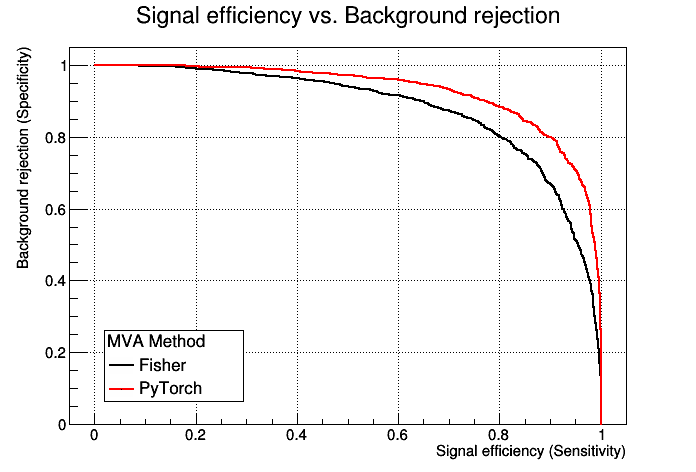

In [14]:
roc = factory.GetROCCurve(dataloader)
roc.Draw()

<hr/>

That is all for this tutorial and with that I've wrapped up my project. Stay tuned for my final post about the GSoC journey at CERN.

Feel free to ask questions below in the comments or on the [root forum](https://root-forum.cern.ch/).

Until next time,
Signing Off!